In [1]:
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [2]:
def get_predict_results_from_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        try:
            y = f['CLASSIFICATIONS/EVENT/signal'][...]
        except KeyError:
            y = f['SpecialKey.Classifications/EVENT/signal'][...]
    return y

def get_AUC_ACC(y, y_pred):
    AUC = roc_auc_score(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    accuracy_scores = []
    # 最多用 1000 個
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y, y_pred > threshold))

    accuracies = np.array(accuracy_scores)
    ACC = accuracies.max()

    return AUC, ACC

def plot_roc_curve(y_true, y_pred, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    AUC, ACC = get_AUC_ACC(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    ax.plot(fpr, tpr, label = f'AUC = {AUC:.3f}  ACC = {ACC:.3f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f'ROC curve of SPANet')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(frameon=False)

    if save_path:
        plt.savefig(save_path, facecolor='White', dpi=300, bbox_inches='tight')
        
    plt.show()

# DM-CPV

## 4b datasets: mixed mass 1M

100%|██████████| 1001/1001 [00:11<00:00, 85.68it/s]


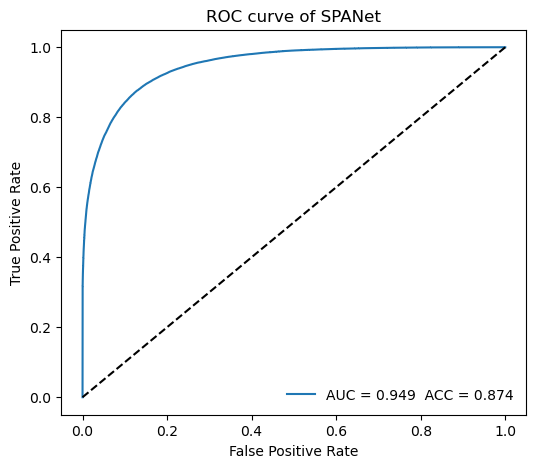

In [3]:
h5_dir = Path('../Sample/SPANet')
file_path = h5_dir / 'triHiggs-4pT40_4b-mix-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs-4pT40_4b-mix-test-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

100%|██████████| 1001/1001 [00:04<00:00, 219.57it/s]


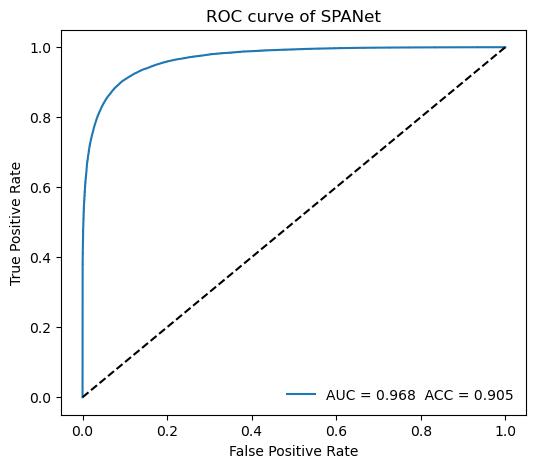

In [4]:
h5_dir = Path('../Sample/SPANet')
file_path = h5_dir / 'triHiggs-4pT40_6b-mix.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs-4pT40_6b-mix-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

## Compute the classification performance at each mass point

In [5]:
h5_dir = Path('../Sample/SPANet')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs-4pT40_4b-mix-test.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs-4pT40_4b-mix-test-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
h5_dir = Path(f'../Sample/SPANet/bkg')
y_test_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_4b-test.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    h5_dir = Path(f'../Sample/SPANet/sig/gghhh_bsm_{m3_m2}')
    y_test_s = get_predict_results_from_h5(h5_dir / 'gghhh-4pT40_4b-test.h5')
    y_prob_s = get_predict_results_from_h5(h5_dir / 'gghhh-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_4b-test-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:15<00:00, 65.08it/s]


In [6]:
h5_dir = Path('../Sample/SPANet')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs-4pT40_6b-mix.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs-4pT40_6b-mix-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
h5_dir = Path(f'../Sample/SPANet/bkg')
y_test_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_6b-1.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    h5_dir = Path(f'../Sample/SPANet/sig/gghhh_bsm_{m3_m2}')
    y_test_s = get_predict_results_from_h5(h5_dir / 'gghhh-4pT40_6b-1.h5')
    y_prob_s = get_predict_results_from_h5(h5_dir / 'gghhh-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/gghhh_bsm_{m3_m2}/gghhh-4pT40_6b-1-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:05<00:00, 192.70it/s]


# TRSM

## 4 mass points mixed: 4b 250k sig + 1M bkg

100%|██████████| 1001/1001 [01:25<00:00, 11.69it/s]


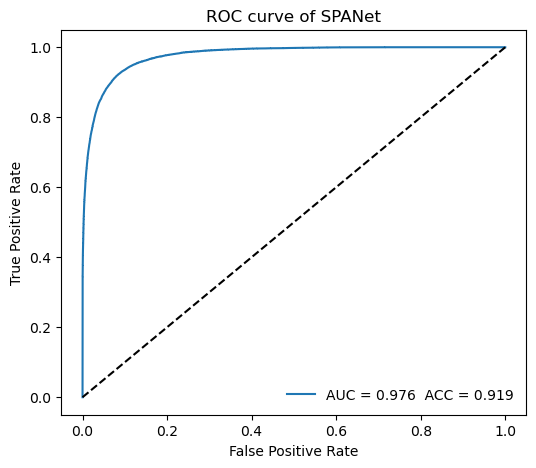

In [8]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

100%|██████████| 1001/1001 [00:35<00:00, 28.39it/s]


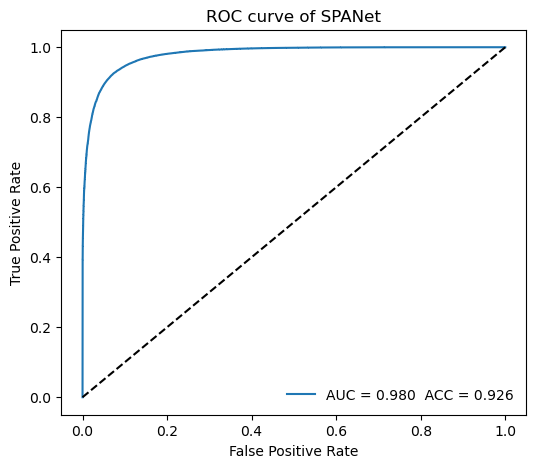

In [9]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

### Compute the classification performance at each mass point

In [4]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_4b-test.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    sig_dir = h5_dir / f'TRSM_{m3_m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3_m2}/gghhh-4pT40_4b-test-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:16<00:00, 61.97it/s]


In [6]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_6b-1.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    sig_dir = h5_dir / f'TRSM_{m3_m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3_m2}/gghhh-4pT40_6b-1-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:05<00:00, 194.69it/s]


## 4 mass points mixed: 4b 750k sig + 1M bkg

100%|██████████| 1001/1001 [00:22<00:00, 44.30it/s]


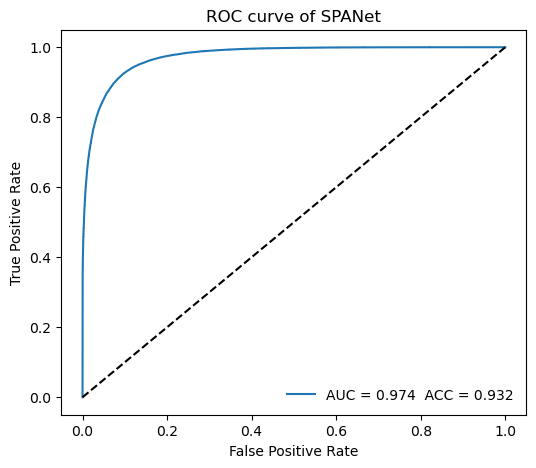

In [3]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

100%|██████████| 1001/1001 [00:04<00:00, 208.13it/s]


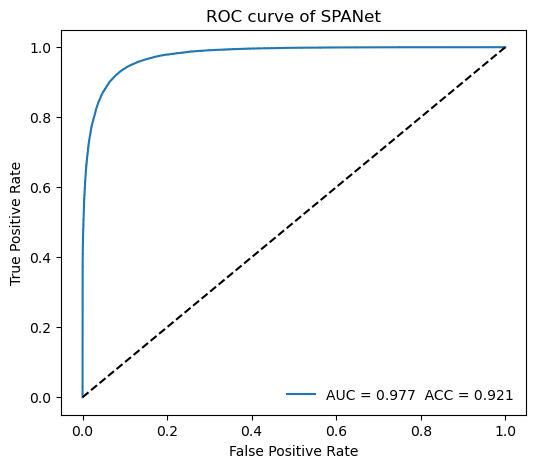

In [4]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

### Compute the classification performance at each mass point

In [5]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_4-test-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_4b-test.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    sig_dir = h5_dir / f'TRSM_{m3_m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3_m2}/gghhh-4pT40_4b-test-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:27<00:00, 36.31it/s]


In [6]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_4-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_6b-1.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

for m3_m2 in ['420_280', '500_275', '500_300', '520_325']:

    sig_dir = h5_dir / f'TRSM_{m3_m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3_m2}/gghhh-4pT40_6b-1-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:05<00:00, 184.29it/s]


## 5 mass points mixed: 4b 250k sig + 1M bkg

100%|██████████| 1001/1001 [00:18<00:00, 54.57it/s]


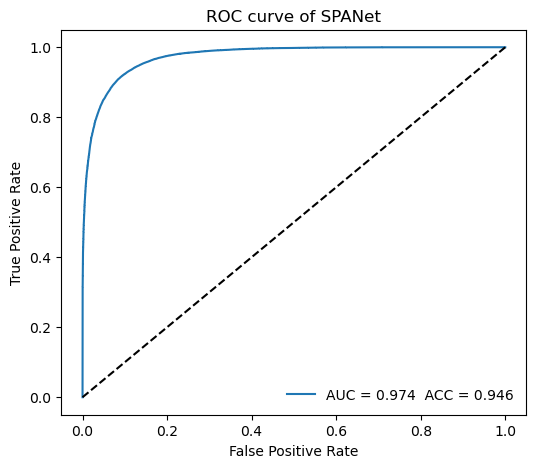

In [3]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_5-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_5-test-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

100%|██████████| 1001/1001 [00:04<00:00, 217.09it/s]


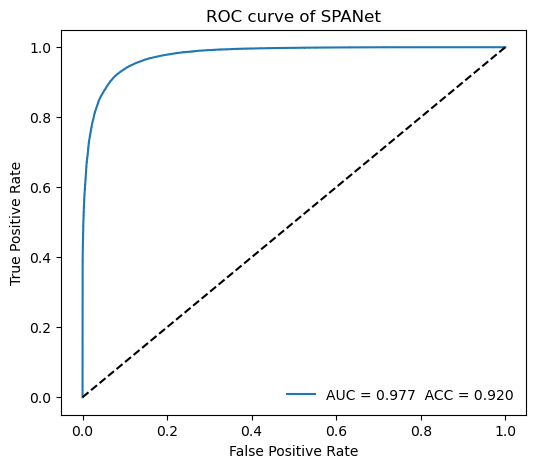

In [4]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_5.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_5-4b_SPANet_predict.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

### Compute the classification performance at each mass point

In [5]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_5-test.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_5-test-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_4b-test.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_4b-test-mix_5-4b_SPANet_predict.h5')[:, 1]

for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]:

    sig_dir = h5_dir / f'TRSM_{m3}_{m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_4b-test-mix_5-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_4b-test-mix_5-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:22<00:00, 44.01it/s]


In [6]:
h5_dir = Path('../Sample/SPANet/TRSM')
y_test = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_5.h5')
y_prob = get_predict_results_from_h5(h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_5-4b_SPANet_predict.h5')[:, 1]

# compute the overall ACC and AUC
AUC, ACC = get_AUC_ACC(y_test, y_prob)

# compute the AUC for each signal mass point
y_test_b = get_predict_results_from_h5('../Sample/SPANet/bkg/pp6b-4pT40_6b-1.h5')
y_prob_b = get_predict_results_from_h5(h5_dir / 'pp6b-4pT40_6b-1-mix_5-4b_SPANet_predict.h5')[:, 1]

for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]:

    sig_dir = h5_dir / f'TRSM_{m3}_{m2}'
    y_test_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1.h5')
    y_prob_s = get_predict_results_from_h5(sig_dir / 'gghhh-4pT40_6b-1-mix_5-4b_SPANet_predict.h5')[:, 1]

    y_test = np.concatenate([y_test_s, y_test_b])
    y_prob = np.concatenate([y_prob_s, y_prob_b])

    auc = roc_auc_score(y_test, y_prob)

    # save the AUC in pandas DataFrame
    data_dict = {'AUC': [auc],
                 'Overall ACC': [ACC],
                 'Overall AUC': [AUC],
                 }
    df = pd.DataFrame(data_dict)
    csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_6b-1-mix_5-SPANet_classifier.csv')
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:05<00:00, 187.64it/s]


## 5 mass points mixed: 4b 1M sig + 1M bkg

In [3]:
predict_method = '4b_SPANet_predict-mix_5-1M'

100%|██████████| 1001/1001 [01:12<00:00, 13.86it/s]


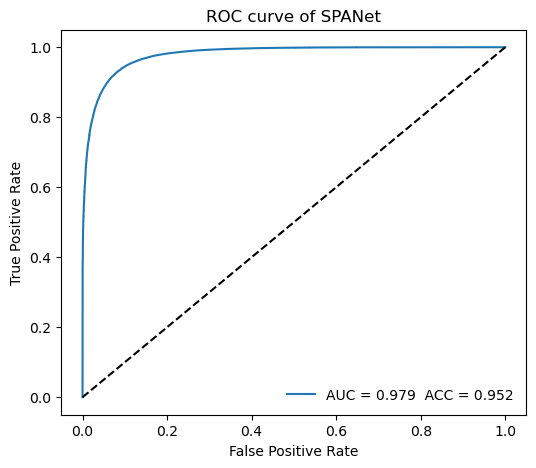

In [4]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_4b-mix_5-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / f'triHiggs_TRSM-4pT40_4b-mix_5-test-{predict_method}.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

100%|██████████| 1001/1001 [00:22<00:00, 44.36it/s]


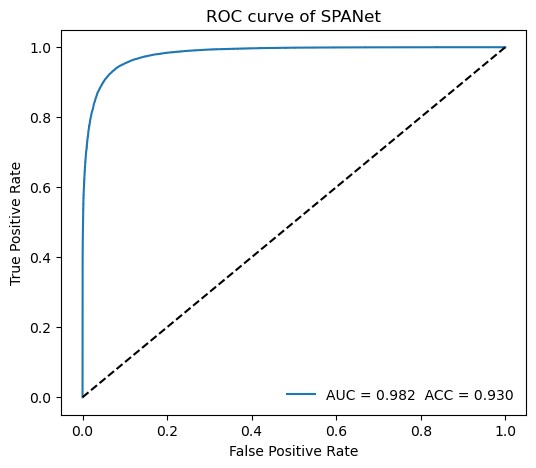

In [5]:
h5_dir = Path('../Sample/SPANet/TRSM')
file_path = h5_dir / 'triHiggs_TRSM-4pT40_6b-mix_5-test.h5'
y_test = get_predict_results_from_h5(file_path)

file_path = h5_dir / f'triHiggs_TRSM-4pT40_6b-mix_5-test-{predict_method}.h5'
y_prob = get_predict_results_from_h5(file_path)

plot_roc_curve(y_test == 1, y_prob[:, 1])

### Compute the classification performance at each mass point

In [8]:
h5_dir = Path('../Sample/SPANet/TRSM')
for n in [4, 6]:

    y_test = get_predict_results_from_h5(h5_dir / f'triHiggs_TRSM-4pT40_{n}b-mix_5-test.h5')
    y_prob = get_predict_results_from_h5(h5_dir / f'triHiggs_TRSM-4pT40_{n}b-mix_5-test-{predict_method}.h5')[:, 1]

    # compute the overall ACC and AUC
    AUC, ACC = get_AUC_ACC(y_test, y_prob)

    # compute the AUC for each signal mass point
    y_test_b = get_predict_results_from_h5(f'../Sample/SPANet/bkg/pp6b-4pT40_{n}b-test.h5')
    y_prob_b = get_predict_results_from_h5(h5_dir / f'pp6b-4pT40_{n}b-test-{predict_method}.h5')[:, 1]

    for m3, m2 in [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]:

        sig_dir = h5_dir / f'TRSM_{m3}_{m2}'
        y_test_s = get_predict_results_from_h5(sig_dir / f'gghhh-4pT40_{n}b-test.h5')
        y_prob_s = get_predict_results_from_h5(sig_dir / f'gghhh-4pT40_{n}b-test-{predict_method}.h5')[:, 1]

        y_test = np.concatenate([y_test_s, y_test_b])
        y_prob = np.concatenate([y_prob_s, y_prob_b])

        auc = roc_auc_score(y_test, y_prob)

        # save the AUC in pandas DataFrame
        data_dict = {'AUC': [auc],
                    'Overall ACC': [ACC],
                    'Overall AUC': [AUC],
                    }
        df = pd.DataFrame(data_dict)
        csv_path = Path(f'../classification_performance/TRSM/TRSM_{m3}_{m2}/gghhh-4pT40_{n}b-test-{predict_method}.csv')
        csv_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(csv_path, index=False)

100%|██████████| 1001/1001 [00:26<00:00, 38.24it/s]
